# Microcontroller Instance Segmentation with COCO dataformat
<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="500">

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/Detectron2-Train-a-Instance-Segmentation-Model/blob/master/Microcontroller_Instance_Segmentation_with_COCO_dataformat.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

## Install detectron2

> **Important**: If you're running on a local machine, be sure to follow the [installation instructions](https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md). This notebook includes only what's necessary to run in Colab.

In [ ]:
!pip install pyyaml==5.1

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.

# exit(0)  # After installation, you may need to "restart runtime" in Colab. This line can also restart runtime

## Get data

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

/home/ben/ssd/anaconda3/envs/dreamerv2/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%pwd

'/home/ben/ssd/code/robot/gym-ras'

## Register data-set

In order to use a dataset with Detectron2 we need to register it. For more information check out the official documentation.

In [2]:
from detectron2.data.datasets import register_coco_instances

_dir = f"data/sim_mask/2023_10_13-15_19_27-no_wrapper-cam_pose_noise_high"
for d in ["train", "test"]:
    register_coco_instances(f"suture_{d}", {}, _dir + "/annotation.json", _dir + f"/images")

[10/13 15:29:47 d2.data.datasets.coco]: Loaded 1000 images in COCO format from data/sim_mask/2023_10_13-15_19_27-no_wrapper-cam_pose_noise_high/annotation.json


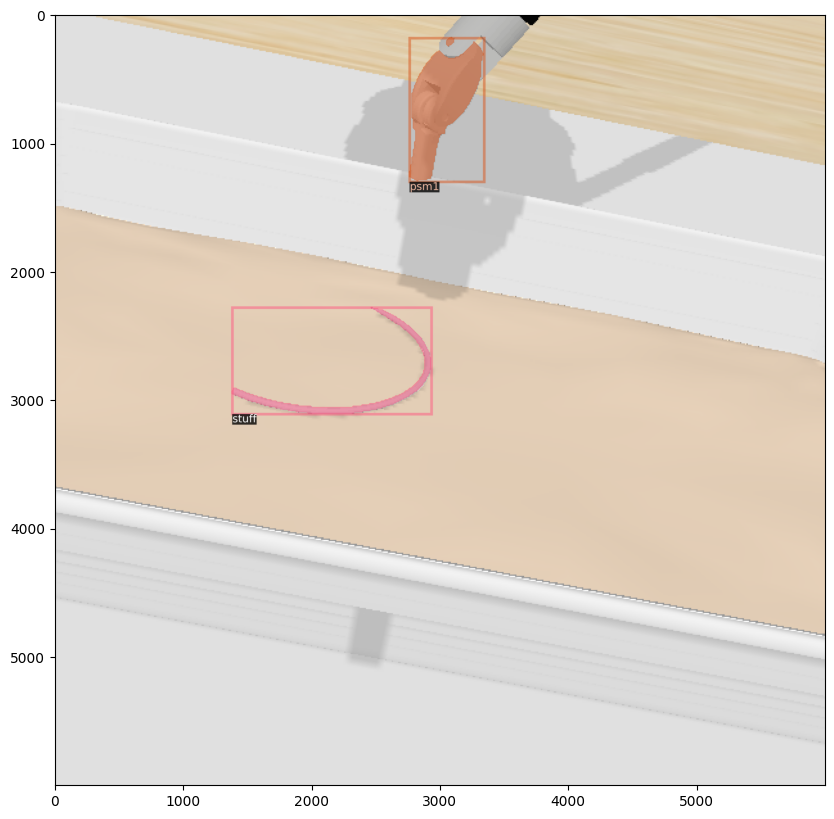

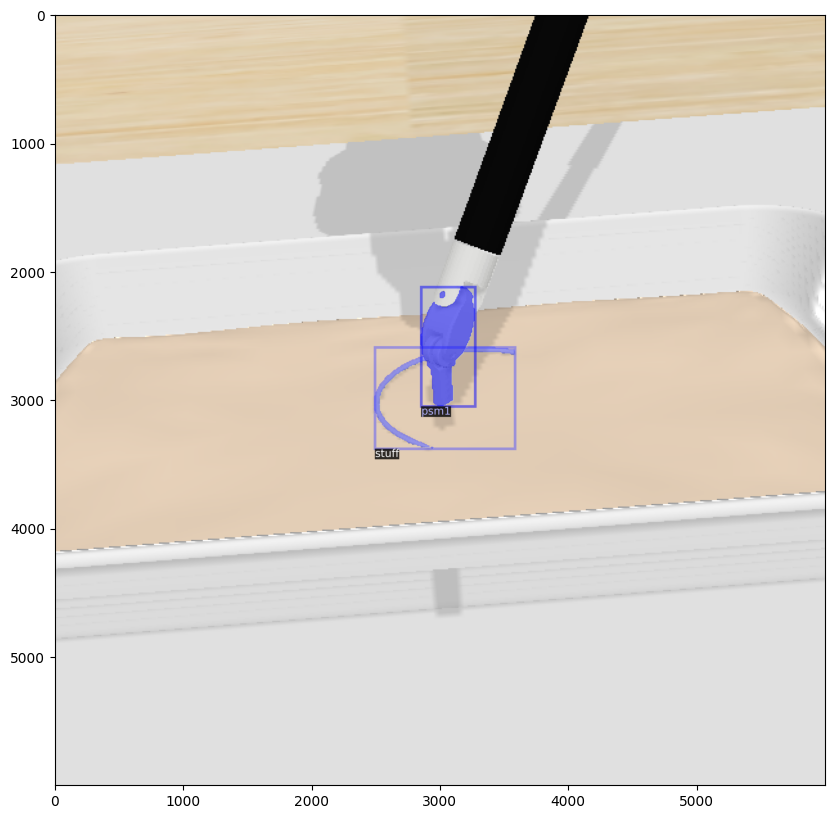

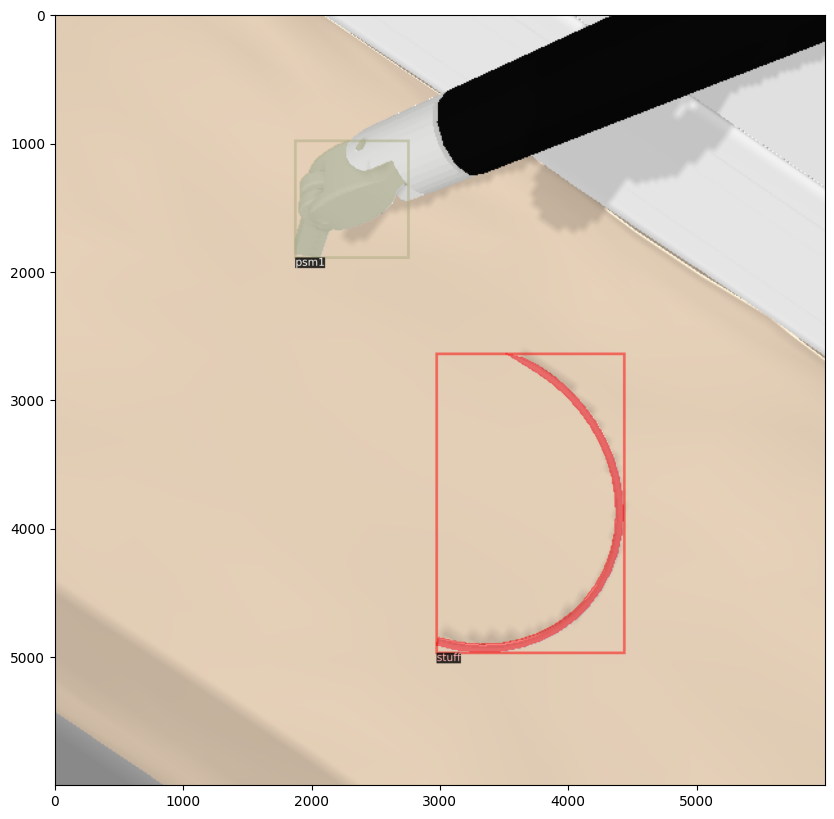

In [3]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog

dataset_dicts = DatasetCatalog.get("suture_train")
microcontroller_metadata = MetadataCatalog.get("suture_train")

for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=microcontroller_metadata, scale=10)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

## Train model

Now, let's fine-tune a pretrained FasterRCNN instance segmentation model on the microcontroller data-set.

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("suture_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 3500
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/13 15:30:49 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

[10/13 15:30:51 d2.engine.train_loop]: Starting training from iteration 0


/home/ben/ssd/anaconda3/envs/dreamerv2/lib/python3.7/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/ben/ssd/anaconda3/envs/dreamerv2/lib/python3.7/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180594101/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/13 15:30:55 d2.utils.events]:  eta: 0:08:10  iter: 19  total_loss: 2.112  loss_cls: 1.092  loss_box_reg: 0.2027  loss_mask: 0.6997  loss_rpn_cls: 0.08952  loss_rpn_loc: 0.01063  time: 0.1394  data_time: 0.0099  lr: 4.9953e-06  max_mem: 1663M
[10/13 15:30:58 d2.utils.events]:  eta: 0:08:04  iter: 39  total_loss: 1.898  loss_cls: 0.9388  loss_box_reg: 0.1936  loss_mask: 0.6885  loss_rpn_cls: 0.07925  loss_rpn_loc: 0.01044  time: 0.1387  data_time: 0.0033  lr: 9.9903e-06  max_mem: 1663M
[10/13 15:31:01 d2.utils.events]:  eta: 0:07:53  iter: 59  total_loss: 1.619  loss_cls: 0.6649  loss_box_reg: 0.2186  loss_mask: 0.6646  loss_rpn_cls: 0.05845  loss_rpn_loc: 0.0117  time: 0.1378  data_time: 0.0028  lr: 1.4985e-05  max_mem: 1663M
[10/13 15:31:04 d2.utils.events]:  eta: 0:07:52  iter: 79  total_loss: 1.377  loss_cls: 0.4448  loss_box_reg: 0.2281  loss_mask: 0.6265  loss_rpn_cls: 0.05277  loss_rpn_loc: 0.01116  time: 0.1382  data_time: 0.0028  lr: 1.998e-05  max_mem: 1669M
[10/13 15:31:06

In [6]:
import torch
torch.save(trainer.model.state_dict(), "./output/segment.pth")

In [9]:
dump_cfg = cfg.dump()
with open("./output/segment.yaml", "w") as file:
    file.write(dump_cfg)

## Use model for inference

Now, we can perform inference on our validation set by creating a predictor object.

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("suture_test", )
predictor = DefaultPredictor(cfg)

[01/13 17:28:07 d2.data.datasets.coco]: Loaded 198 images in COCO format from ../data/seg/label/ambf_origin_scene/annotations.json


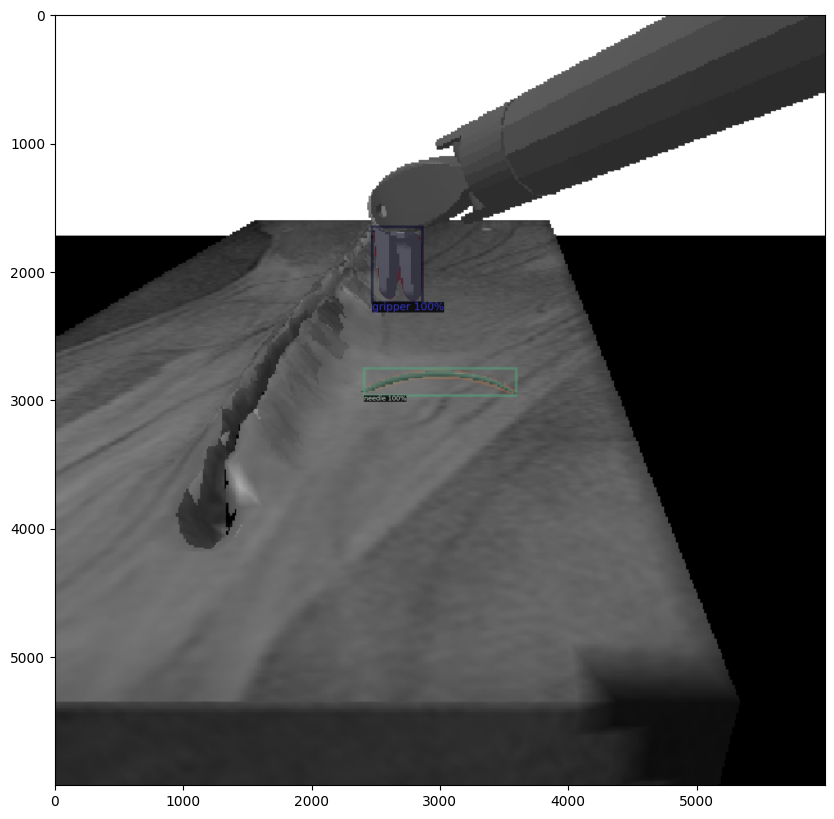

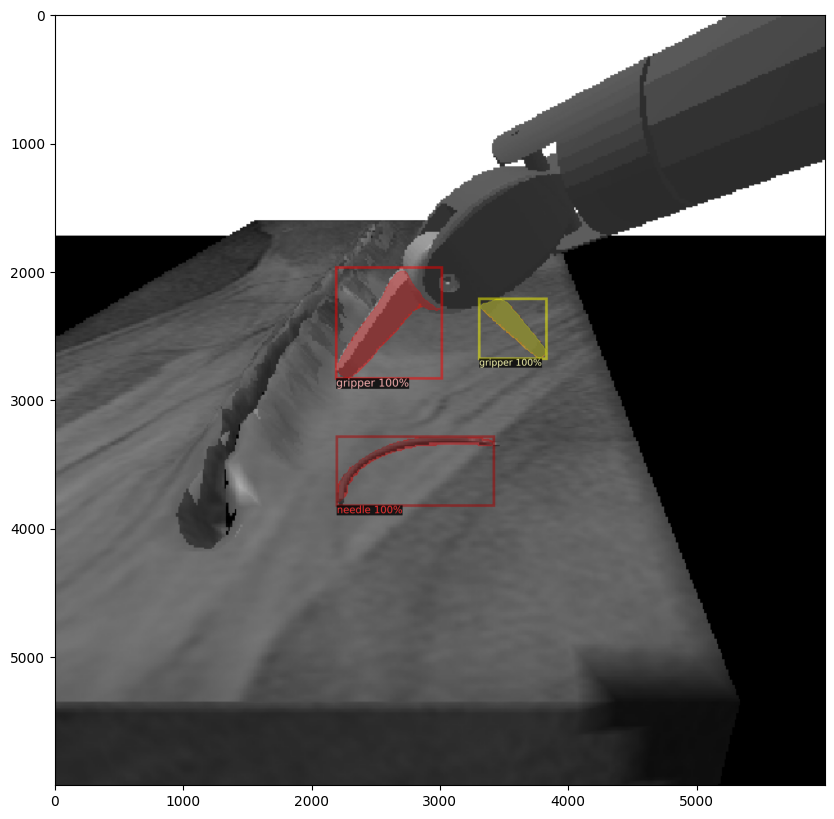

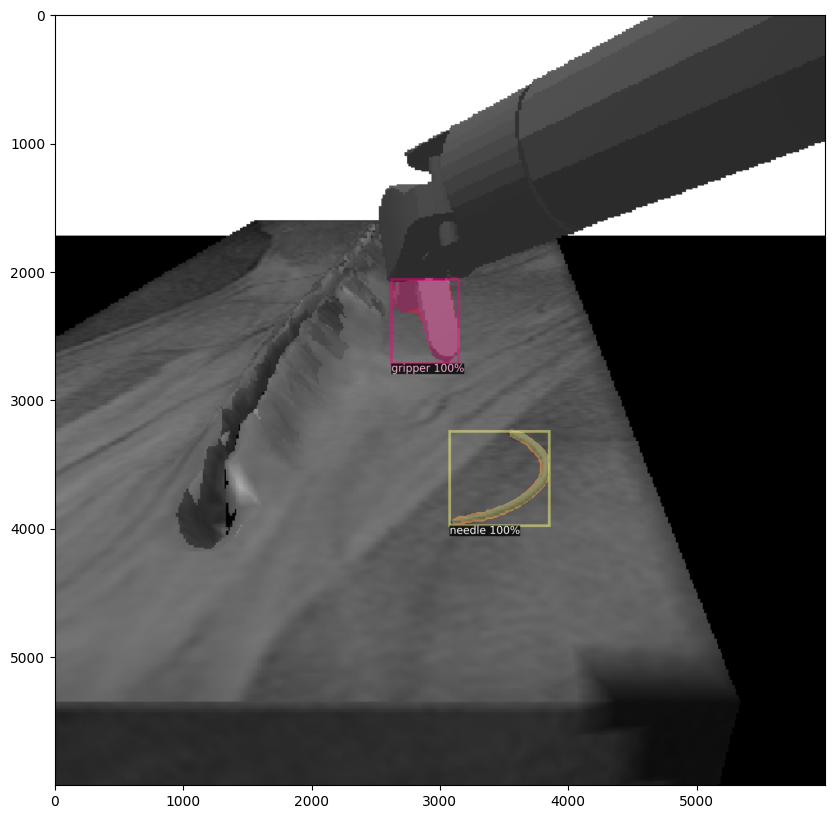

In [7]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("suture_test")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=microcontroller_metadata, 
                   scale=10, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

In [8]:
outputs['instances']

Instances(num_instances=3, image_height=600, image_width=600, fields=[pred_boxes: Boxes(tensor([[365.0177, 158.4084, 391.7351, 191.9597],
        [400.4290, 169.0099, 438.0309, 214.6714],
        [372.5173, 285.7968, 425.4512, 343.2517]], device='cuda:0')), scores: tensor([0.9993, 0.9988, 0.9964], device='cuda:0'), pred_classes: tensor([0, 0, 1], device='cuda:0'), pred_masks: tensor([[[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False]],

        [[False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         [False, False, False,  ..., False, False, False],
         ...,
         [False, False, False,  ..., False, False, False],
 

In [7]:
type(img)

numpy.ndarray